In [1]:
import sys,os
import multiprocessing
from joblib import Parallel, delayed
import time

import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})
from matplotlib import cm,colors

In [2]:
# n_cpu = multiprocessing.cpu_count() - 1
# pool  = multiprocessing.Pool(processes=n_cpu)

# results = pool.starmap(func=test,iterable=[(i,) for i in range(10)])
# pool.close()

# results

# finite difference solver

In [3]:
def get_U_fde(dt,x,V=lambda t: np.full(t.shape[0],0),m=1):
    dx = x[1] - x[0]
    N  = x.shape[0]
    H  = -(np.diag(np.full(N-1,1),k=-1) - np.diag(np.full(N,2),k=0) + np.diag(np.full(N-1,1),k=1))/2/m/dx**2 + np.diag(V(x),k=0)
    H[0][:2]   = np.array([1,0])
    H[-1][-2:] = np.array([0,1])
    print(H)
    
    U = np.eye(N) - complex(0,dt)*H
    return U

def get_U_fdi(dt,x,V=lambda t: np.full(t.shape[0],0),m=1):
    dx = x[1] - x[0]
    N  = x.shape[0]
    H  = -(np.diag(np.full(N-1,1),k=-1) - np.diag(np.full(N,2),k=0) + np.diag(np.full(N-1,1),k=1))/2/m/dx**2 + np.diag(V(x),k=0)
    H[0][:2]   = np.array([1,0])
    H[-1][-2:] = np.array([0,1])
    
    U = np.eye(N) + complex(0,dt)*H
    return U

def U_psi_ft(dt,x,psi0,m=1,V=lambda t: np.full(t.size,0)):
    dx = x[1] - x[0]
    N  = x.size
    dk = 2*np.pi/N/dx
    
    k  = np.fft.fftfreq(N)
    k *= dk/(k[1] - k[0])
    
    psi_t  = np.fft.fft(psi0,norm='ortho')
    # psi_t *= dx*np.sqrt(N)/np.sqrt(2*np.pi)*np.exp(-complex(0,1)*k*x[0])
    psi_t *= np.exp(-complex(0,1)*k**2*dt/2/m)
    
    return np.exp(-complex(0,1)*V(x)*dt)*np.fft.ifft(psi_t,norm='ortho')

In [4]:
# def gauss_psi(x,t,a=1,m=1):
#     gam = complex(1,2*a*t/m)
#     return (2*a/np.pi)**(1/4)*1/np.sqrt(gam)*np.exp(-a*x**2/gam)

test explicit evolution

In [5]:
# x  = np.linspace(-10,10,50)
# dx = x[1] - x[0]

# x0,sig = 0,1
# psi0    = (2*np.pi*sig**2)**(-1/4)*np.exp(-(x-x0)**2/4/sig**2)

# dt = 0.001
# print(dt/dx**2)
# U  = get_U_fde(dt,x)
# np.abs(np.linalg.eigvals(U))

In [6]:
# # for _ in rho[0]:
# rho0 = np.abs(psi0)**2
# plt.plot(x,rho0,'k.')
# temp = gauss_psi(x,0,a=1/4/sig**2)
# plt.plot(x,np.real(temp*temp.conjugate()),'k-')

# Nt = 5000
# psi = (U**Nt)@psi0
# rho = np.abs(psi)**2
# plt.plot(x,rho,'r.')
# temp = gauss_psi(x,Nt*dt,a=1/4/sig**2)
# plt.plot(x,np.abs(temp)**2,'r-')


# plt.show()

test implicit evolution

In [7]:
# x  = np.linspace(-10,10,100)
# dx = x[1] - x[0]

# x0,sig = 0,1
# psi0    = (2*np.pi*sig**2)**(-1/4)*np.exp(-(x-x0)**2/4/sig**2)

# dt = 0.001
# print(dt/dx**2)
# U = get_U_fdi(dt,x)
# print(np.amax(np.abs(U*U.conjugate().T - np.eye(x.size))))
# np.abs(1/np.linalg.eigvals(U))

In [8]:
# # for _ in rho[0]:
# rho0 = np.abs(psi0)**2
# print(np.sum(rho0)*dx)
# plt.plot(x,rho0,'k.')
# temp = gauss_psi(x,0,a=1/4/sig**2)
# plt.plot(x,np.real(temp*temp.conjugate()),'k-')

# Nt = 1000
# psi = np.linalg.solve((U**Nt),psi0)
# rho = np.abs(psi)**2
# print(np.sum(rho)*dx)
# plt.plot(x,rho,'r.')
# temp = gauss_psi(x,Nt*dt,a=1/4/sig**2)
# plt.plot(x,np.abs(temp)**2,'r-')

# plt.show()

# FFT solver

In [9]:
def f(x,sig=1):
    return np.exp(-x**2/4/sig**2)/(2*np.pi*sig**2)**(1/4)

def F(k,sig=1):
    return (2*sig**2/np.pi)**(1/4)*np.exp(-k**2*sig**2)

In [10]:
x   = np.linspace(-10,10,200)
dx  = x[1] - x[0]
N   = x.size
f_  = f(x,sig=1)

dk  = 2*np.pi/N/dx
k   = np.fft.fftfreq(N)
f_t = np.fft.fft(f_,norm='ortho')
f_t,k = np.fft.fftshift(f_t),np.fft.fftshift(k)
k   *= dk/(k[1] - k[0])
f_t *= dx*np.sqrt(N)/np.sqrt(2*np.pi)*np.exp(-complex(0,1)*k*x[0])

In [11]:
print(dx*np.sum(f_**2))
print(dk*np.sum(np.abs(f_t)**2))

1.0
1.0000000000000002


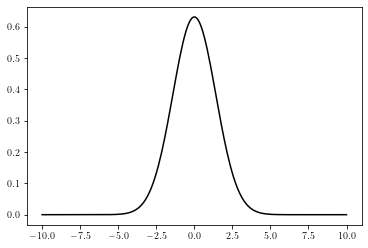

In [12]:
plt.plot(x,f_,'k-')
plt.show()

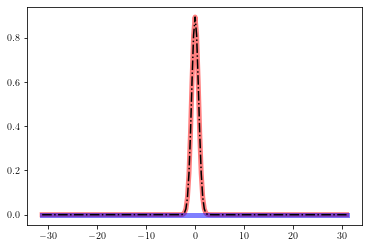

In [13]:
plt.plot(k,f_t.real,'r-',lw=5,alpha=0.5)
plt.plot(k,f_t.imag,'b-',lw=5,alpha=0.5)
plt.plot(k,F(k,sig=1),'k-.')
plt.show()

# Test: Gaussian wave packet propagation

In [14]:
def Psi0_gwp(x,m=1,sig=1,k=0,x0=0):
    return (2*np.pi*sig**2)**(-1/4)*np.exp(-(x-x0)**2/4/sig**2 + complex(0,1)*k*x)
    
def Psi2_gwp(x,t,m=1,sig=1,k=0,x0=0):
    return 1/np.sqrt(2*np.pi*sig**2)*2*sig**2*m/np.sqrt(4*sig**4*m**2+t**2)*np.exp(-2*m**2*sig**2*(x-x0-k*t/m)**2/(4*sig**4*m**2+t**2))

test that $\Delta t = 0$ gives back same wave function

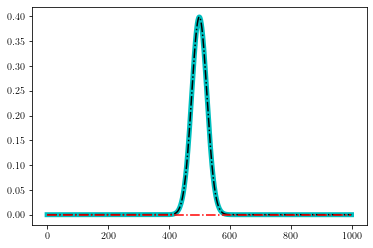

In [15]:
x = np.linspace(-20,20,1000)
psi0 = Psi2_gwp(x,0)
plt.plot(psi0,'c-',lw=5)


psi  = U_psi_ft(0,x,psi0)
plt.plot(psi.real,'k-.')
plt.plot(psi.imag,'r-.')

plt.show()

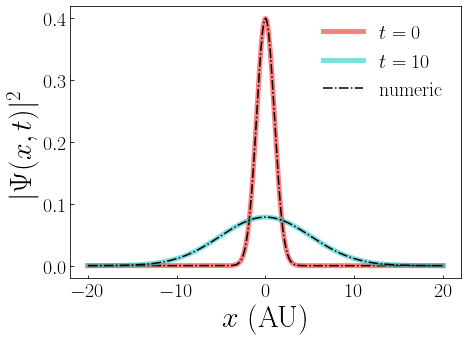

In [16]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

m    = 1
sig  = 1
k    = 0
x0   = 0
args = (m,sig,k,x0)
x = np.linspace(-20,20,500)
dx = x[1] - x[0]

psi0 = Psi0_gwp(x,*args)
ax.plot(x,np.abs(psi0)**2,color='r',ls='-',lw=5,alpha=0.5,label=r'$t = 0$')


dt  = 0.01
t   = np.arange(0,10,dt)
Psi = [psi0]
for _ in t[1:]:
    temp = U_psi_ft(dt,x,Psi[-1],m=m)
    Psi.append(temp)
ax.plot(x,np.abs(Psi[0])**2,color='k',ls='-.')

exact = Psi2_gwp(x,t[-1],*args)
ax.plot(x,exact,color='c',ls='-',lw=5,alpha=0.5,label=r'$t = %.2g$'%t[-1])
ax.plot(x,np.abs(Psi[-1])**2,color='k',ls='-.',label=r'$\rm numeric$')

# print(dx*np.sum(np.abs(Psi[0])**2))
# print(dx*np.sum(np.abs(Psi[-1])**2))

ax.set_xlabel(r'$x~({\rm AU})$',size=30)
ax.set_ylabel(r'$|\Psi(x,t)|^2$',size=30)
ax.legend(fontsize=20,loc='upper right',frameon=False)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

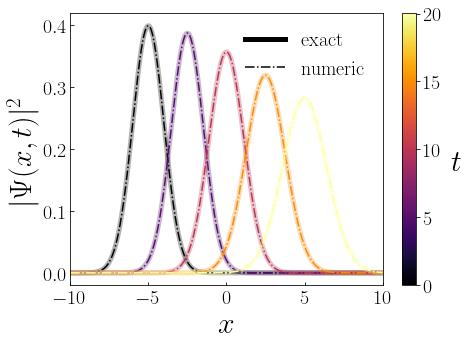

In [17]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

m    = 10
sig  = 1
k    = 5
x0   = -5
args = (m,sig,k,x0)
x = np.linspace(-20,20,10000)
dx = x[1] - x[0]

psi0 = Psi0_gwp(x,*args)
# ax.plot(x,np.abs(psi0)**2,color='r',ls='-',lw=5,alpha=0.5,label=r'$t = 0$')


dt   = 0.01
t    = np.arange(0,20+dt,dt)
cmap = cm.inferno
norm = colors.Normalize(vmin=t[0],vmax=t[-1])

Psi = [psi0]
for _ in t[1:]:
    temp = U_psi_ft(dt,x,Psi[-1],m=m)
    Psi.append(temp)

for i in range(len(t)):
    _ = t[i]
    if np.isclose(_,np.round(_)) and np.round(_) % 5 == 0:
        ax.plot(x,Psi2_gwp(x,_,*args),color=cmap(norm(_)),ls='-',lw=5,alpha=0.3)#,label=r'$t = 0$')
        ax.plot(x,np.abs(Psi[i])**2,color=cmap(norm(_)),ls='-.')

# print(dx*np.sum(np.abs(Psi[0])**2))
# print(dx*np.sum(np.abs(Psi[-1])**2))

ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$|\Psi(x,t)|^2$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
ax.set_xlim(-10,10)

ax.plot([],[],'k-',lw=5,label=r'$\rm exact$')
ax.plot([],[],'k-.',label=r'$\rm numeric$')
ax.legend(fontsize=20,loc='upper right',frameon=False)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax,orientation='vertical')
cbar.set_label(r'$t$',size=30,rotation=0,labelpad=15)
cbar.ax.tick_params(labelsize=20)
# cbar.set_ticks([0,1,2,3,4,5])

plt.show()
fig.savefig('gauss_wave-prop.pdf',bbox_inches='tight')

# Scattering from a delta source

In [54]:
def V(x,V0=1,sig=1):
    return V0*np.exp(-x**2/2/sig**2)/np.sqrt(2*np.pi*sig**2)

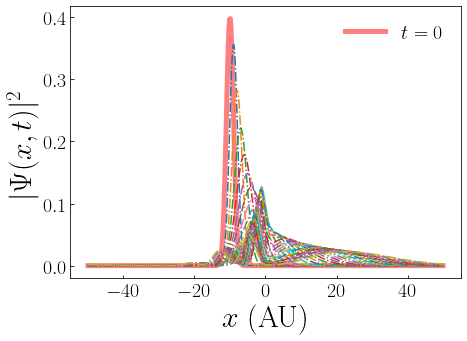

In [55]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

m    = 1
sig  = 1
k    = 1
x0   = -10
args = (m,sig,k,x0)
x = np.linspace(-50,50,500)
dx = x[1] - x[0]

psi0 = Psi0_gwp(x,*args)
ax.plot(x,np.abs(psi0)**2,color='r',ls='-',lw=5,alpha=0.5,label=r'$t = 0$')

V0  = 1
dt  = 0.01
t   = np.arange(0,30,dt)
Psi = [psi0]
for _ in t[1:]:
    temp = U_psi_ft(dt,x,Psi[-1],m=m,V=lambda t: V(t,V0=1))
    Psi.append(temp)
    if np.isclose(_,np.round(_)):
        ax.plot(x,np.abs(Psi[-1])**2,ls='-.')

ax.set_xlabel(r'$x~({\rm AU})$',size=30)
ax.set_ylabel(r'$|\Psi(x,t)|^2$',size=30)
ax.legend(fontsize=20,loc='upper right',frameon=False)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

In [117]:
# def get_RT(k,m=1,sig_x=10,x0=-50,xm=100,N=5000,V0=1,sig_V=0.1,dt=0.01,max_iter=int(1e5),tol=1e-3):
#     x  = np.linspace(-xm,xm,N)
#     dx = x[1] - x[0]
#     li = x < -5*sig_V
#     ri = x > 5*sig_V
    
#     psi0 = Psi0_gwp(x,m=m,sig=sig_x,k=k,x0=x0)
#     for i in range(max_iter):
#         psi  = U_psi_ft(dt,x,psi0,m=m,V=lambda t: V(t,V0=V0,sig=sig_V))
#         drho = dx*np.abs(psi)**2
        
#         R = np.sum(drho[li])
#         T = np.sum(drho[ri])
        
#         if 1 - (R + T) < tol and (x0 + k*i*dt/m) > 0:
#             # print(i)
#             break
#         else:
#             psi0 = psi.copy()
            
#     return np.array([R,T])


def get_RT(k,m=1,M1=10,M2=500,dt=0.001,V0=1,sig_V=0.1,max_iter=int(1e6),atol=1e-5,rtol=1e-3):
    sig_x = 5*M1/k
    x0    = -5*sig_x
    xm    = 10*sig_x
    dx    = sig_x/M2
    N     = np.round(2*xm/dx).astype(int)
    print(sig_x,x0,xm,dx,N)
    print(-2*x0*m/k/dt)
    
    x  = np.linspace(-xm,xm,N)
    dx = x[1] - x[0]
    li = x < -5*sig_V
    ri = x > 5*sig_V
 
    psi0 = Psi0_gwp(x,m=m,sig=sig_x,k=k,x0=x0)
    R0   = dx*np.sum(np.abs(psi0[li])**2)
    T0   = dx*np.sum(np.abs(psi0[ri])**2)
    for i in range(max_iter):
        if i % 10000 == 0: print(i)
        psi = U_psi_ft(dt,x,psi0,m=m,V=lambda t: V(t,sig=sig_V,V0=V0))
        rho = np.abs(psi)**2
        
        R = dx*np.sum(rho[li])
        T = dx*np.sum(rho[ri])
        
        adiff = max(abs(R-R0),abs(T-T0))
        rdiff = max(abs(1-R/(R0+1e-100)),abs(1-T/(T0+1e-100)))

        cond1 = (2*x0 + k*i*dt/m > 0)
        cond2 = (rdiff < rtol or adiff < atol)
        if cond1 and cond2:
            # print(i,rdiff<rtol,adiff<atol)
            break
        else:
            psi0  = psi.copy()
            R0,T0 = R.copy(),T.copy()
    
    # t = i*dt
    # print(t**2/(4*sig_x**4*m**2))
            
    return np.array([R,T])

def Te(k,m=1,V0=1):
    return k**2/(k**2 + m**2*V0**2)

In [129]:
m  = 1
V0,sig_V = 1,0.1
k  = np.linspace(1,10,5)

# print(get_RT(1,m=m,M2=300,dt=0.1,V0=V0,sig_V=sig_V))
# print(Te(1,m=m,V0=V0))

start = time.time()
results = Parallel(n_jobs=4)(delayed(get_RT)(_,m=m,M2=300,dt=0.01,V0=V0,sig_V=sig_V) for _ in k)
R,T = np.array(results).T
end = time.time()
print(end - start)

14.949804067611694


time taken for 20 points: 284.0371460914612 sec or ?? min

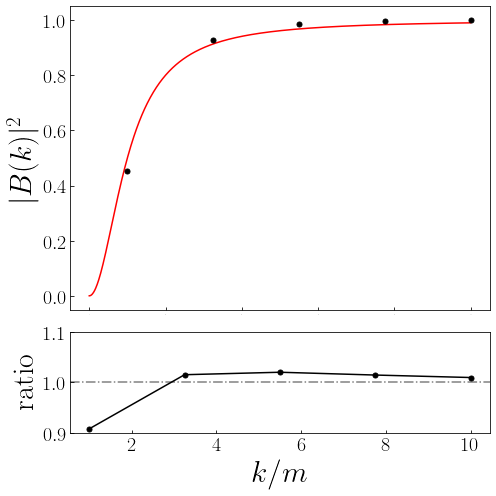

In [130]:
nrows,ncols = 2,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7,7),gridspec_kw={'height_ratios':[6,2]})

ke  = np.linspace(0,10,1000)
Te_ = Te(ke,V0=V0,m=m)

ax[0].plot(ke,Te_,'r-',label=r'${\rm exact}$')
ax[0].plot(k,T,color='k',ls='None',marker='.',markersize=10,label=r'$\rm numeric$')

ax[0].set_ylabel(r'$|B(k)|^2$',size=30)
ax[0].tick_params(axis='both',which='major',labelsize=20,direction='in')
ax[0].tick_params(axis='x',which='major',labelsize=0)
# ax[0].legend(fontsize=20,frameon=False,loc='center')
# ax[0].set_xlim(0,1.05)
# text =(
#     r'\begin{align*}'
#     rf'V_0 &= {V0} \\'
#     rf'a &= {a} \\'
#     r'm &= 1'
#     r'\end{align*}'
# )
# ax[0].text(s=text,size=20,x=0.975,y=0.05,ha='right',va='bottom',transform=ax[0].transAxes)

#####

Te_ = Te(k,m=m,V0=V0)
ax[1].plot(k,T/Te_,color='k',ls='-',marker='.',markersize=10)
ax[1].axhline(1,color='k',ls='-.',alpha=0.5)

ax[1].tick_params(axis='both',which='major',labelsize=20,direction='in')
ax[1].set_xlabel(r'$k/m$',size=30)
ax[1].set_ylabel(r'$\rm ratio$',size=30)
# ax[1].set_xlim(0,1.05)
ax[1].set_ylim(0.9,1.1)


fig.align_labels()
plt.tight_layout()
plt.show()

0.9999997163123708
0.9999997163118753
0.5793795411111373 0.4206201752007381
0.5


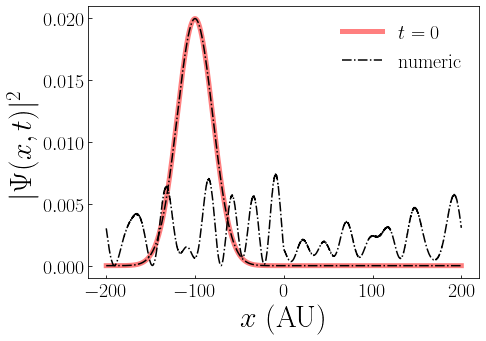

In [88]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

m    = 1
sig  = 20
k    = 0.1
x0   = -100
args = (m,sig,k,x0)
x = np.linspace(-200,200,5000)
dx = x[1] - x[0]

psi0 = Psi0_gwp(x,*args)
ax.plot(x,np.abs(psi0)**2,color='r',ls='-',lw=5,alpha=0.5,label=r'$t = 0$')

V0  = 0.1
dt  = 0.1
t   = np.arange(0,4000,dt)
Psi = [psi0]
for _ in t[1:]:
    temp = U_psi_ft(dt,x,Psi[-1],m=m,V=lambda t: V(t,V0=V0,sig=0.1))
    Psi.append(temp)
ax.plot(x,np.abs(Psi[0])**2,color='k',ls='-.')

# exact = Psi2_gwp(x,t[-1],*args)
# ax.plot(x,exact,color='c',ls='-',lw=5,alpha=0.5,label=r'$t = %.2g$'%t[-1])
ax.plot(x,np.abs(Psi[-1])**2,color='k',ls='-.',label=r'$\rm numeric$')

print(dx*np.sum(np.abs(Psi[0])**2))
print(dx*np.sum(np.abs(Psi[-1])**2))
print(dx*np.sum(np.abs(Psi[-1][x<0])**2),dx*np.sum(np.abs(Psi[-1][x>0])**2))
print(Te(k,V0=V0,m=m))

ax.set_xlabel(r'$x~({\rm AU})$',size=30)
ax.set_ylabel(r'$|\Psi(x,t)|^2$',size=30)
ax.legend(fontsize=20,loc='upper right',frameon=False)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

# Scattering from a square barrier

In [47]:
def A2(k,m=1,V0=1,a=1):
    if k**2 < 2*m*V0:
        kappa = np.sqrt(2*m*V0-k**2)
        return 4*m**2*V0**2*np.sinh(kappa*a)**2/(4*kappa**2*k**2 + 4*m**2*V0**2*np.sinh(kappa*a)**2)
    elif k**2 == 2*m*V0:
        return k**2*a**2/(4 + a**2*k**2)
    else:
        kp = np.sqrt(k**2 - 2*m*V0)
        return 4*m**2*V0**2*np.sin(kp*a)**2/(4*kp**2*k**2 + 4*m**2*V0**2*np.sin(kp*a)**2)
    
def B2(k,m=1,V0=1,a=1):
    return 1 - A2(k,m,V0,a)

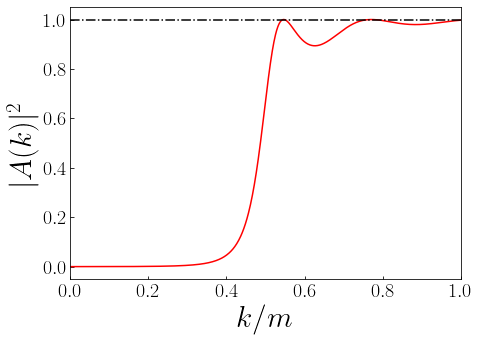

In [48]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

k   = np.linspace(0,1,1000)

m,V0,a = 1,0.1,10
B2_  = np.array([B2(_,m=m,V0=V0,a=a) for _ in k])

ax.plot(k,B2_,'r')
ax.axhline(1,color='k',ls='-.')

ax.set_xlabel(r'$k/m$',size=30)
ax.set_ylabel(r'$|A(k)|^2$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
ax.set_xlim(0,1)
# ax.set_ylim(0.99,1.01)

plt.show()

In [43]:
def V(x,a=1,V0=1):
    return V0*(np.abs(x)<a/2)

In [44]:
def get_RT(k,m=1,M1=10,M2=500,dt=0.001,V0=1,a=1,max_iter=int(1e6),atol=1e-5,rtol=1e-3):
    sig_x = 5*M1/k
    x0    = -(a/2 + 5*sig_x)
    xm    = 10*sig_x + a/2
    dx    = sig_x/M2
    N     = np.round(2*xm/dx).astype(int)
    # print(-2*x0*m/k/dt)
    
    x  = np.linspace(-xm,xm,N)
    dx = x[1] - x[0]
    li = x < -a/2
    ri = x > a/2
 
    psi0 = Psi0_gwp(x,m=m,sig=sig_x,k=k,x0=x0)
    R0   = dx*np.sum(np.abs(psi0[li])**2)
    T0   = dx*np.sum(np.abs(psi0[ri])**2)
    for i in range(max_iter):
        # if i % 10000 == 0: print(i)
        psi = U_psi_ft(dt,x,psi0,m=m,V=lambda t: V(t,a=a,V0=V0))
        rho = np.abs(psi)**2
        
        R = dx*np.sum(rho[li])
        T = dx*np.sum(rho[ri])
        
        adiff = max(abs(R-R0),abs(T-T0))
        rdiff = max(abs(1-R/(R0+1e-100)),abs(1-T/(T0+1e-100)))

        cond1 = (2*x0 + k*i*dt/m > 0)
        cond2 = (rdiff < rtol or adiff < atol)
        if cond1 and cond2:
            # print(i,rdiff<rtol,adiff<atol)
            break
        else:
            psi0  = psi.copy()
            R0,T0 = R.copy(),T.copy()
    
    # t = i*dt
    # print(t**2/(4*sig_x**4*m**2))
            
    return np.array([R,T])

In [49]:
m    = 1
V0,a = 0.1,10
k    = np.linspace(0.1,1,50)

# print(get_RT(0.3,m=m,M2=500,dt=0.1,V0=V0,a=a))
# print(B2(0.9,m=m,V0=V0,a=a))
start = time.time()
results = Parallel(n_jobs=4)(delayed(get_RT)(_,m=m,M2=500,dt=0.1,V0=V0,a=a) for _ in k)
R,T = np.array(results).T
end = time.time()
print(end - start)
# R,T  = np.array([get_RT(_,V0=V0,a=a) for _ in k]).T
# print(T)

time taken for 50 points: 1228.27166390419 sec or 20.5 min

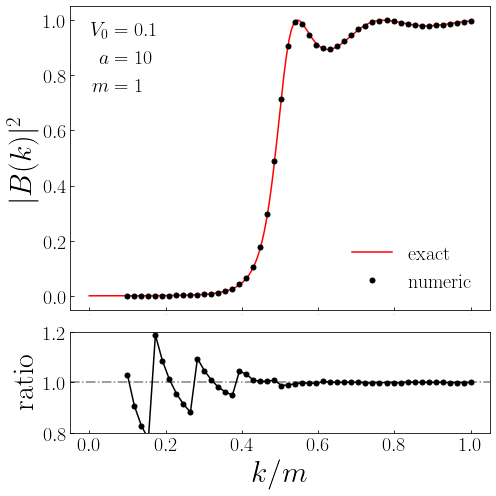

In [53]:
nrows,ncols = 2,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7,7),gridspec_kw={'height_ratios':[6,2]})

ke  = np.linspace(0,k[-1],1000)
Te_ = np.array([B2(_,m=m,V0=V0,a=a) for _ in ke])
ax[0].plot(ke,Te_,'r-',label=r'${\rm exact}$')
ax[0].plot(k,T,color='k',ls='None',marker='.',markersize=10,label=r'$\rm numeric$')

# ax[0].semilogy()
ax[0].set_ylabel(r'$|B(k)|^2$',size=30)
ax[0].tick_params(axis='both',which='major',labelsize=20,direction='in')
ax[0].tick_params(axis='x',which='major',labelsize=0)
ax[0].legend(fontsize=20,frameon=False,loc='lower right')
text =(
    r'\begin{align*}'
    rf'V_0 &= {V0} \\'
    rf'a &= {a} \\'
    rf'm &= {m}'
    r'\end{align*}'
)
ax[0].text(s=text,size=20,x=0.05,y=0.95,ha='left',va='top',transform=ax[0].transAxes)

#####

Te_ = np.array([B2(_,m=m,V0=V0,a=a) for _ in k])
ax[1].plot(k,T/(Te_+1e-100),color='k',ls='-',marker='.',markersize=10)
ax[1].axhline(1,color='k',ls='-.',alpha=0.5)

ax[1].tick_params(axis='both',which='major',labelsize=20,direction='in')
ax[1].set_xlabel(r'$k/m$',size=30)
ax[1].set_ylabel(r'$\rm ratio$',size=30)
ax[1].set_xlim(-0.05,1.05)
ax[1].set_ylim(0.8,1.2)

fig.align_labels()

plt.tight_layout()
plt.show()
fig.savefig(r'square_barrier.pdf',bbox_inches='tight')

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

m    = 1
sig  = 1
k    = 1
x0   = -10
args = (m,sig,k,x0)
x = np.linspace(-50,50,500)
dx = x[1] - x[0]

psi0 = Psi0_gwp(x,*args)
ax.plot(x,np.abs(psi0)**2,color='r',ls='-',lw=5,alpha=0.5,label=r'$t = 0$')


V0  = 10
dt  = 0.01
t   = np.arange(0,30,dt)
Psi = [psi0]
for _ in t[1:]:
    temp = U_psi_ft(dt,x,Psi[-1],m=m,V=lambda t: V(t,a=1,V0=10))
    Psi.append(temp)
    if np.isclose(_,np.round(_)):
        ax.plot(x,np.abs(Psi[-1])**2,ls='-.')

ax.set_xlabel(r'$x~({\rm AU})$',size=30)
ax.set_ylabel(r'$|\Psi(x,t)|^2$',size=30)
ax.legend(fontsize=20,loc='upper right',frameon=False)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

m    = 10
sig  = 10
k    = 5
x0   = -50
args = (m,sig,k,x0)
x = np.linspace(-100,100,5000)
dx = x[1] - x[0]
print(-x0*m/k)

psi0 = Psi0_gwp(x,*args)
ax.plot(x,np.abs(psi0)**2,color='r',ls='-',lw=5,alpha=0.5,label=r'$t = 0$')

V0  = 1
a   = 1
dt  = 0.001
t   = np.arange(0,200,dt)
# print(len(t))
Psi = [psi0]
for _ in t[1:]:
    temp = U_psi_ft(dt,x,Psi[-1],m=m,V=lambda t: V(t,a=a,V0=V0))
    Psi.append(temp)
ax.plot(x,np.abs(Psi[0])**2,color='k',ls='-.')

# exact = Psi2_gwp(x,t[-1],*args)
# ax.plot(x,exact,color='c',ls='-',lw=5,alpha=0.5,label=r'$t = %.2g$'%t[-1])
ax.plot(x,np.abs(Psi[-1])**2,color='k',ls='-.',label=r'$\rm numeric$')

print(dx*np.sum(np.abs(Psi[0])**2))
print(dx*np.sum(np.abs(Psi[-1])**2),dx*np.sum(np.abs(Psi[-1][x<0])**2),dx*np.sum(np.abs(Psi[-1][x>0])**2))

ax.set_xlabel(r'$x~({\rm AU})$',size=30)
ax.set_ylabel(r'$|\Psi(x,t)|^2$',size=30)
ax.legend(fontsize=20,loc='upper right',frameon=False)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

# Math stuff

In [ ]:
x,y,k,x0 = sp.symbols(r'x y k x_0',real=True)
t,m,sig      = sp.symbols(r't m \sigma',real=True,positive=True)

expr  = -(-m*(x-y)**2/(2*sp.I*t) - (y - x0)**2/(4*sig**2) + sp.I*k*y)
a,b,c = sp.Poly(expr.series(y),y).coeffs()

In [ ]:
display(a)
display(b)
display(c)

In [ ]:
psi = 1/sp.sqrt(2*sp.pi*sig**2)*m/(2*sp.pi*t)*sp.pi/sp.Abs(a)*sp.exp(2*sp.re((b**2/4/a-c).expand()).factor())
sp.integrate(psi,(x,-sp.oo,sp.oo))


In [ ]:
psi = 1/sp.sqrt(sp.sqrt((2*sp.pi*sig**2)))*sp.exp(-(x-x0)**2/(4*sig**2))*sp.exp(sp.I*k*x)
sp.integrate(psi.conjugate()*-sp.I*psi.diff(x),(x,-sp.oo,sp.oo))

In [ ]:
psi = 1/sp.sqrt(sp.sqrt((2*sp.pi*sig**2)))*sp.sqrt(sp.pi/a)*sp.sqrt(m/(2*sp.pi*sp.I*t))*sp.exp(b**2/4/a-c)
(sp.Abs(psi)**2).simplify()

In [ ]:
rho = 1/sp.sqrt((2*sp.pi*sig**2))*2*m*sig**2/(2*m*sig**2+t**2)*sp.exp(-2*m**2*sig**2*(x-(x0+k*t/m))**2/(4*sig**4*m**2+t**2))
sp.integrate(rho,(x,-sp.oo,sp.oo))
